In [ ]:
# !pip install statsforecast
# !pip install mlforecast
# !pip install nixtlats>=0.1.0





: 

# Importing Necessary Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from nixtlats import TimeGPT

c:\Users\zeesh\anaconda3\envs\forecasting_env\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
c:\Users\zeesh\anaconda3\envs\forecasting_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 6.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# Data Reading and Processing

In [4]:
file_path = "walmart.csv"
df = pd.read_csv(file_path)

#Covert Date into Datetime Format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Set "Date" column as index
df.set_index('Date', inplace=True)

# Resample data into Weekly frequency. Although this is not required. Keeping it so that one can change into 'MS' if needed.
df_resampled = df.resample('W').sum()

df_resampled.reset_index(inplace=True)

df_resampled = df_resampled[["Date","Weekly_Sales"]]

print(df_resampled.head())

        Date  Weekly_Sales
0 2010-02-07   49750740.50
1 2010-02-14   48336677.63
2 2010-02-21   48276993.78
3 2010-02-28   43968571.13
4 2010-03-07   46871470.30


# Data Visualization

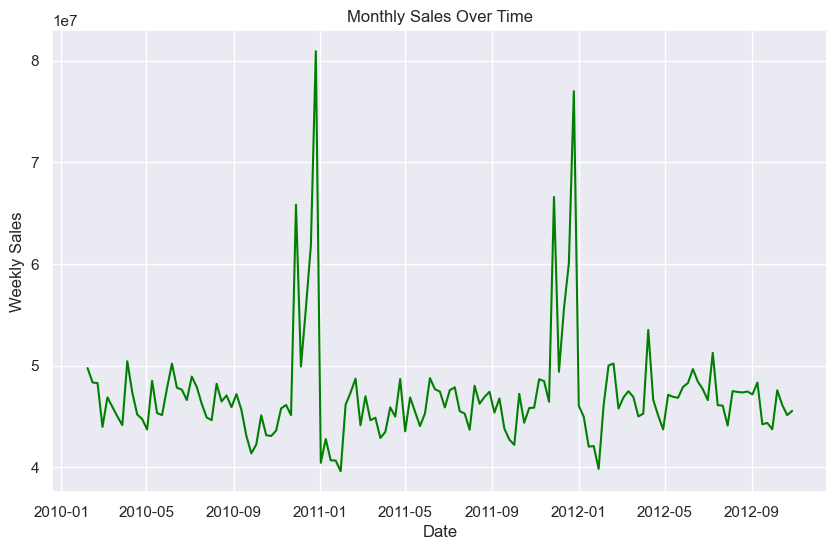

In [5]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y='Weekly_Sales', data=df_resampled, color='green')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

# STL Decomposition of the Data

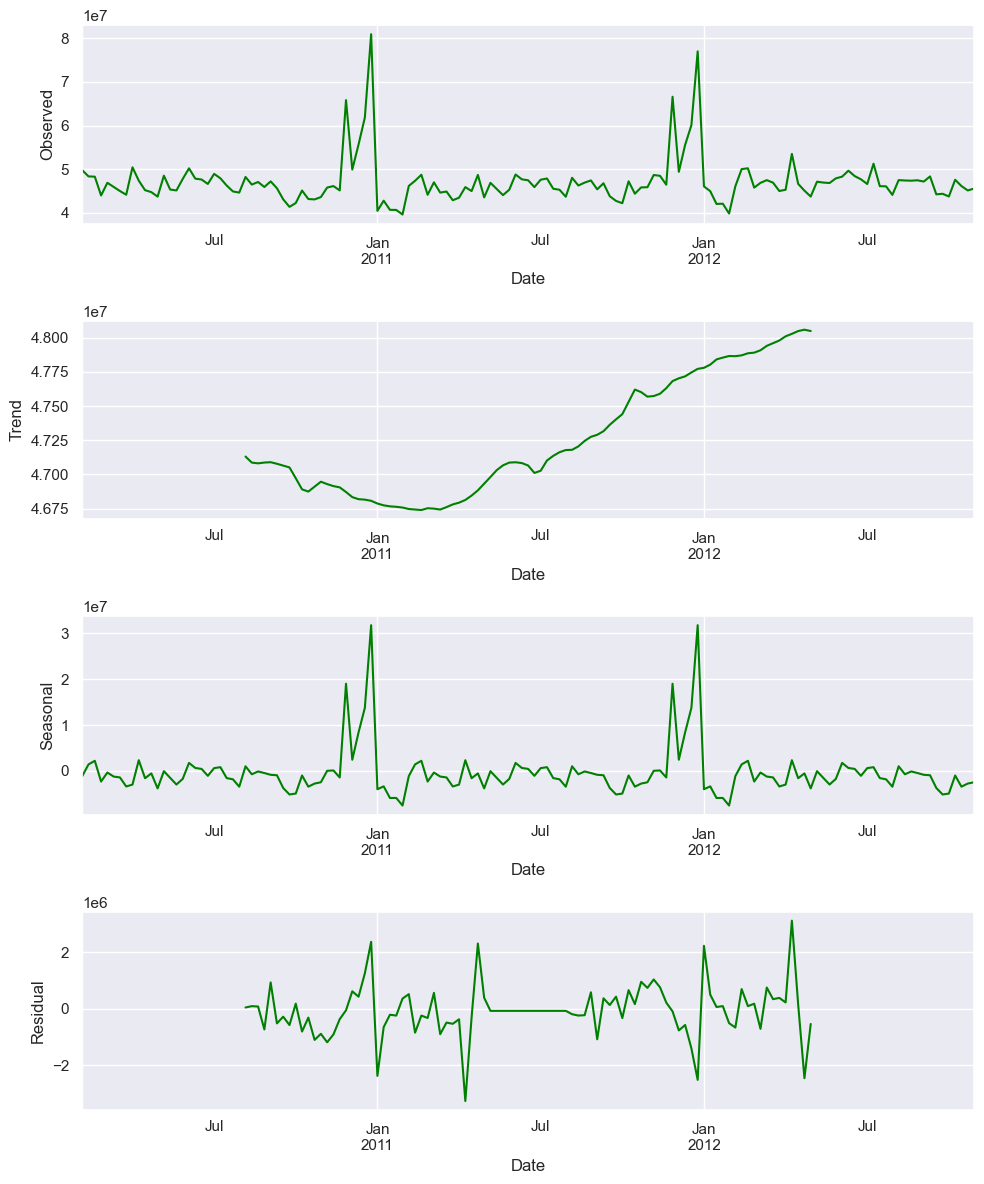

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df_resampled.set_index('Date', inplace=True)
result = seasonal_decompose(df_resampled['Weekly_Sales'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

result.observed.plot(ax=ax1, color='green')
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='green')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='green')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

df_resampled.reset_index(inplace=True)

# Train & Test Split

In [7]:
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 114
Test set size: 29


# Forecasting with StatsForecast – AutoARIMA

In [8]:
train_ = pd.DataFrame({'unique_id':[1]*len(train),'ds': train["Date"], "y":train["Weekly_Sales"]})
test_ = pd.DataFrame({'unique_id':[1]*len(test),'ds': test["Date"], "y":test["Weekly_Sales"]})

sf = StatsForecast(models = [AutoARIMA(season_length = 52)],freq = 'W')

sf.fit(train_)
sf_prediction = sf.predict(h=len(test))
sf_prediction.rename(columns={'ds': 'Date'}, inplace=True)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [9]:
sf_prediction

,Date,AutoARIMA
unique_id,,
1,2012-04-15,48190620.0
1,2012-04-22,51893984.0
1,2012-04-29,46747324.0
1,2012-05-06,50079252.0
1,2012-05-13,48663436.0
1,2012-05-20,47263892.0
1,2012-05-27,48510748.0
1,2012-06-03,51989288.0
1,2012-06-10,50887028.0


# Forecasting with MLForecast – Linear Regression, LGBM Regression, XGB Regression and Random Forest Regression

In [10]:
models = [LinearRegression(),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]
@njit
def rolling_mean_7(x):
    return rolling_mean(x, window_size=7)
@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)
    
#Defining the Model Parameters
fcst = MLForecast(models=models,freq='W',lags=[7,14,28],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_7, rolling_mean_14],
        14: [rolling_mean_7, rolling_mean_14]
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],
    target_transforms=[Differences([7])])
    
#Fitting the Model and Generating Forecasts
fcst.fit(train_)
ml_prediction = fcst.predict(len(test_))
ml_prediction.rename(columns={'ds': 'Date'}, inplace=True)

In [11]:
ml_prediction


,unique_id,Date,LinearRegression,LGBMRegressor,XGBRegressor,RandomForestRegressor
0,1,2012-04-15,4.184221e+07,4.758883e+07,48272444.0,4.583376e+07
1,1,2012-04-22,5.063865e+07,5.128578e+07,46844924.0,4.630367e+07
2,1,2012-04-29,4.372516e+07,4.966874e+07,48599132.0,4.675738e+07
3,1,2012-05-06,4.629398e+07,4.458644e+07,45108292.0,4.590455e+07
4,1,2012-05-13,4.846285e+07,4.547622e+07,46374772.0,4.629285e+07
5,1,2012-05-20,5.633588e+07,4.902203e+07,45185880.0,4.660480e+07
6,1,2012-05-27,4.759709e+07,5.139651e+07,52955464.0,5.271923e+07
7,1,2012-06-03,4.266039e+07,4.295058e+07,46969656.0,4.618368e+07
8,1,2012-06-10,4.890681e+07,4.220633e+07,47883880.0,4.648442e+07
9,1,2012-06-17,4.705928e+07,4.422534e+07,46730188.0,4.639994e+07


# TimeGPT Model

In [12]:


#Importing TimeGPT
from nixtlats import TimeGPT

In [13]:
os.environ['TIMEGPT_TOKEN'] = "Your Token"
timegpt = TimeGPT(token=os.environ['TIMEGPT_TOKEN'])

In [14]:
timegpt_fcst = timegpt.forecast(df=train, h=len(test), time_col='Date', target_col='Weekly_Sales', freq='W')
print(timegpt_fcst.head())

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: W-SUN


ApiError: status_code: 401, body: {'data': None, 'message': 'Invalid API key', 'details': 'Key not found', 'code': 'A12', 'requestID': 'Y5TW6RLMGU', 'support': 'If you have questions or need support, please email ops@nixtla.io'}

In [19]:
result = test.copy()
# result.drop("index", axis=1, inplace=True)
result.set_index("Date", inplace=True)
result["AutoARIMA_fcst"]=sf_prediction["AutoARIMA"].values
result["LinearRegression_fcst"]=ml_prediction["LinearRegression"].values
result["LGBM_fcst"]=ml_prediction["LGBMRegressor"].values
result["XGB_fcst"]=ml_prediction["XGBRegressor"].values
result["RandomForest_fcst"]=ml_prediction["RandomForestRegressor"].values
# result["TimeGPT_fcst"]=timegpt_fcst["TimeGPT"].values
print(result.head())

            Weekly_Sales  AutoARIMA_fcst  LinearRegression_fcst     LGBM_fcst  \
Date                                                                            
2012-04-15   46629261.41      48190620.0           4.184221e+07  4.758883e+07   
2012-04-22   45072529.78      51893984.0           5.063865e+07  5.128578e+07   
2012-04-29   43716798.89      46747324.0           4.372516e+07  4.966874e+07   
2012-05-06   47124197.93      50079252.0           4.629398e+07  4.458644e+07   
2012-05-13   46925878.99      48663436.0           4.846285e+07  4.547622e+07   

              XGB_fcst  RandomForest_fcst  
Date                                       
2012-04-15  48272444.0       4.583376e+07  
2012-04-22  46844924.0       4.630367e+07  
2012-04-29  48599132.0       4.675738e+07  
2012-05-06  45108292.0       4.590455e+07  
2012-05-13  46374772.0       4.629285e+07  


In [21]:
import numpy as np

In [22]:
def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
        'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))
    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

# Extract 'Weekly_Sales' as actuals
actuals = result['Weekly_Sales']


error_metrics_dict = {}


for col in result.columns[1:]:  # Exclude 'Weekly_Sales'
    predicted_values = result[col]
    error_metrics_dict[col] = calculate_error_metrics(actuals, predicted_values)['Value'].values  # Extracting 'Value' column


error_metrics_df = pd.DataFrame(error_metrics_dict)
error_metrics_df.insert(0, 'Metric', calculate_error_metrics(actuals, actuals)['Metric'].values)  # Adding 'Metric' column


print(error_metrics_df)

  Metric  AutoARIMA_fcst  LinearRegression_fcst     LGBM_fcst      XGB_fcst  \
0    MAE    2.438376e+06           4.923236e+06  3.590455e+06  2.149079e+06   
1   RMSE    2.775494e+06           6.836633e+06  4.214252e+06  2.672836e+06   
2   MAPE    5.267297e+00           1.076790e+01  7.663017e+00  4.596564e+00   
3  SMAPE    5.093221e+00           9.861231e+00  7.659919e+00  4.542677e+00   
4  MdAPE    5.280470e+00           6.030154e+00  6.204948e+00  3.498337e+00   
5  GMRAE    4.306181e-02           5.429682e-02  6.221986e-02  3.396031e-02   

   RandomForest_fcst  
0       1.977053e+06  
1       2.492108e+06  
2       4.208990e+00  
3       4.180090e+00  
4       2.731467e+00  
5       2.953477e-02  


C:\Users\zeesh\AppData\Local\Temp\ipykernel_7464\845962499.py:11: RuntimeWarning: divide by zero encountered in log
  'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))


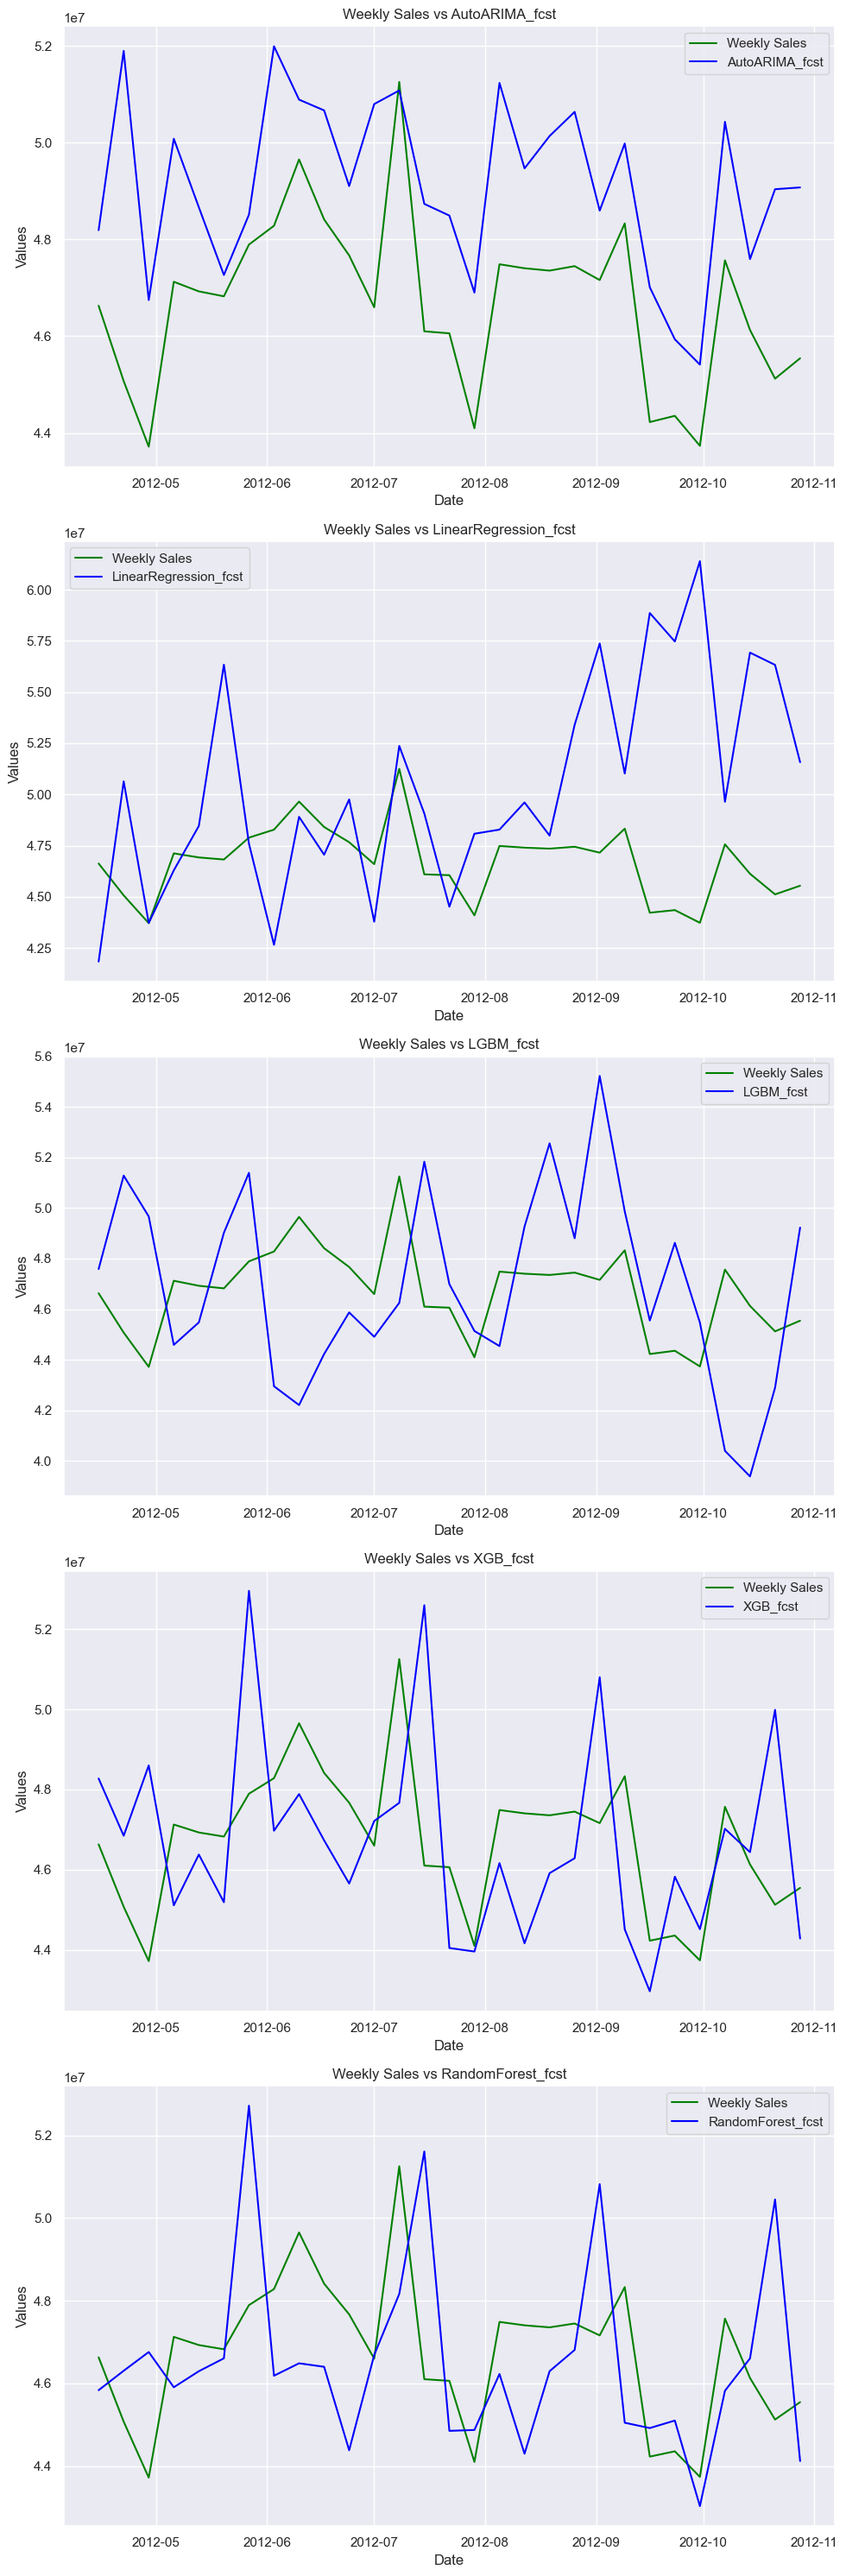

In [23]:
# Set seaborn style to darkgrid
sns.set(style="darkgrid")

# Create subplots for each prediction column
num_cols = len(result.columns[1:])
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 6 * num_cols))

# Loop through each prediction column and plot on separate subplot
for i, col in enumerate(result.columns[1:]):  # Exclude 'Weekly_Sales'
    axes[i].plot(result.index, result['Weekly_Sales'], label='Weekly Sales', color='green')
    axes[i].plot(result.index, result[col], label=col, color='blue')
    axes[i].set_title(f'Weekly Sales vs {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Values')
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()